In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import seaborn as sns
print('seaborn: ', sns.__version__)

seaborn:  0.11.2


In [2]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("data/kddcup.data.corrected", sep=",", names=columns, index_col=None)


In [3]:
# Filter to only 'http' attacks
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)


In [4]:
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))

encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 


In [6]:
# Check the variables with highest correlation with 'label'
df2 = df.copy()
label_corr = df2.corr()['label']

In [7]:
# Filter out anything that has null entry or is not weakly correlated
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
train_cols

['src_bytes',
 'hot',
 'num_compromised',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate']

In [8]:
labels = df2['label']
# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size = 0.15, random_state = 42)


In [9]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


In [11]:
import tensorflow
tensorflow.__version__

'2.7.0'

In [12]:
from tensorflow.keras.utils import to_categorical

y_train =  to_categorical(y_train)
y_test =  to_categorical(y_test)
y_val =  to_categorical(y_val)

In [13]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701, 2)

x_val:(105926, 13)
y_val:(105926, 2)

x_test:(93464, 13)
y_test:(93464, 2)


In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
# The input layer requires you to specify the dimensionality of the x-features (and not the number of samples)
input_layer = Input(shape=(13))
h1 = Dense(26, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = L2(l2=1e-5))(input_layer)
h2 = Dense(26, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = L2(l2=1e-5))(h1)
h3 = Dense(26, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = L2(l2=1e-5))(h2)
h4 = Dense(6, activation='relu', kernel_initializer = 'he_uniform', kernel_regularizer = L2(l2=1e-5))(h3)
output_layer = Dense(2, activation='softmax', kernel_regularizer = L2(l2=1e-5))(h4)

# Creating a model by specifying the input layer and output layer
model = Model(input_layer, output_layer)

In [26]:
es = EarlyStopping(patience=5, min_delta=1e-3, monitor='val_loss', restore_best_weights=True)

callbacks = [es]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [27]:
epochs = 20
batch_size = 128

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/20
3311/3311 [==============================] - 16s 5ms/step - loss: 0.3778 - accuracy: 0.9962 - val_loss: 0.0052 - val_accuracy: 0.9999
Epoch 2/20
3311/3311 [==============================] - 14s 4ms/step - loss: 0.0264 - accuracy: 0.9995 - val_loss: 0.0131 - val_accuracy: 0.9991
Epoch 3/20
3311/3311 [==============================] - 14s 4ms/step - loss: 0.0542 - accuracy: 0.9990 - val_loss: 0.0105 - val_accuracy: 0.9999
Epoch 4/20
3311/3311 [==============================] - 14s 4ms/step - loss: 0.0097 - accuracy: 0.9984 - val_loss: 0.0102 - val_accuracy: 0.9963
Epoch 5/20
3311/3311 [==============================] - 15s 5ms/step - loss: 0.0079 - accuracy: 0.9968 - val_loss: 0.0129 - val_accuracy: 0.9925
Epoch 6/20
3311/3311 [==============================] - 15s 4ms/step - loss: 0.0073 - accuracy: 0.9972 - val_loss: 0.0039 - val_accuracy: 0.9999
Epoch 7/20
3311/3311 [==============================] - 14s 4ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0062 - val_ac

In [28]:
model.evaluate(x_test, y_test)

2921/2921 [==============================] - 8s 3ms/step - loss: 0.0032 - accuracy: 0.9999


[0.003189682262018323, 0.9999144077301025]

In [35]:
preds = model.predict(x_test)

# One hot to the original label encodings
y_true = y_test.argmax(axis=1)

# Derive the label predictions from the probability scores
y_preds = preds.argmax(axis=1)

# Compute precision, recall, f1 scores
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1_measure = f1_score(y_true, y_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Measure: {f1_measure}")

Precision: 0.9895287958115183
Recall: 0.9964850615114236
F1-Measure: 0.9929947460595447


In [33]:
roc_auc_score(y_true, y_preds)

0.9982102362296339

Text(33.0, 0.5, 'True Label')

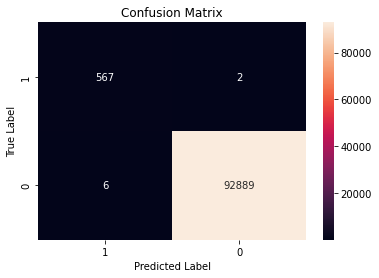

In [34]:
cm = confusion_matrix(y_true, y_preds)
plt.title("Confusion Matrix")
ax = sns.heatmap(cm, annot=True, fmt='0.0f')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')